In [111]:
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import cv2
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

import sys
sys.path.insert(1, "/zhome/19/0/64415/Deep-Learning-Project/")

from CopActNet.tools import visualizer

In [101]:
# Load images and labels from pickle file

images = pickle.load(open("../Annotations/Frames_forannotation.pkl","rb"))
y = pickle.load(open("../Annotations/y_vector.pkl","rb"))

In [102]:
# Simplify labels to only count cyclists

for i in range(len(y)):
    if y[i] == 2:
        y[i] = 1
    elif y[i] in [3, 4, 5]:
        y[i] = 2
    elif y[i] in [6, 7, 8, 9]:
        y[i] = 3

In [103]:
# Shuffle images and split into training and test set

images_train, images_test, y_train, y_test = train_test_split(images, y, test_size=0.15, random_state=42)

#sh_ints = list(range(len(y)))
#random.shuffle(sh_ints)

#images = images[sh_ints]
#y = [y[i] for i in sh_ints]

#images_train = images[:270]
#images_test = images[270:]
#y_train = y[:270]
#y_test = y[270:]

print(images_train.shape)
print(images_test.shape)
print(len(y_train))
print(len(y_test))

(280, 128, 128, 3)
(50, 128, 128, 3)
280
50


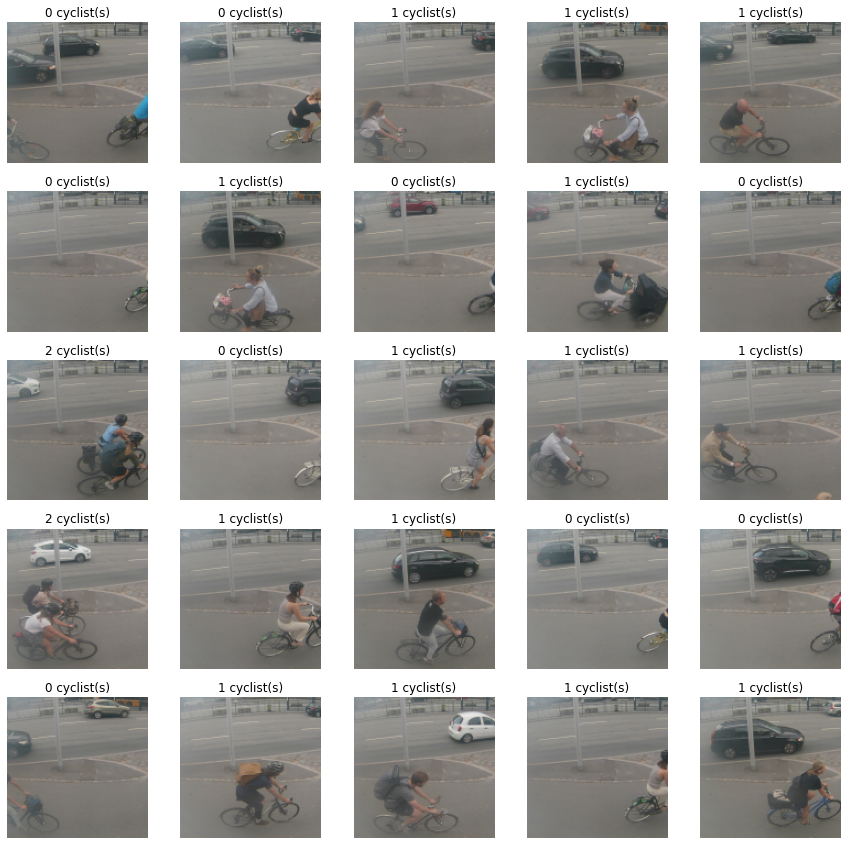

In [104]:
spr = 5
spc = 5

fig, axs = plt.subplots(spr, spc, figsize=(15, 15))
for i in range(spr):
    for j in range(spc):
        im = images_train[spc*i+j]
        axs[i, j].imshow(im[:,:,[2, 1, 0]])
        axs[i, j].set_title(str(y_train[spc*i+j])+' cyclist(s)')
        axs[i, j].axis('off')

In [105]:
# Initialising the CNN
model = Sequential(
    [
        Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'),
        MaxPooling2D(pool_size = (2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation = 'relu'),
        MaxPooling2D(pool_size = (2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation = 'relu'),
#        MaxPooling2D(pool_size = (2, 2)),
#        BatchNormalization(),
#        Conv2D(32, (3, 3), activation = 'relu'),
        Flatten(),
        Dense(units = 128, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 128, activation = 'relu'),
        Dense(units = 4, activation = 'softmax')
    ]
)

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 63, 63, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                      

In [106]:
batch_size = 10
EPOCHS = 10
iter_per_epoch = len(images_train) // batch_size
test_per_epoch = len(images_test) // batch_size

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_gen = train_datagen.flow(images_train, y_train, batch_size=batch_size)
test_gen = test_datagen.flow(images_test, y_test, batch_size=batch_size)

# Fitting the model
m = model.fit(    #m = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = test_gen,
       validation_steps = test_per_epoch,
       verbose = 1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
       )

Epoch 1/10
28/28 [==============================] - 4s 93ms/step - loss: 4.1258 - accuracy: 0.5000 - val_loss: 4.3848 - val_accuracy: 0.7400
Epoch 2/10
28/28 [==============================] - 2s 79ms/step - loss: 1.3024 - accuracy: 0.6214 - val_loss: 2.1714 - val_accuracy: 0.7400
Epoch 3/10
28/28 [==============================] - 2s 79ms/step - loss: 0.9827 - accuracy: 0.6393 - val_loss: 0.7660 - val_accuracy: 0.7400
Epoch 4/10
28/28 [==============================] - 2s 82ms/step - loss: 0.7299 - accuracy: 0.7286 - val_loss: 0.8962 - val_accuracy: 0.7400
Epoch 5/10
28/28 [==============================] - 2s 85ms/step - loss: 0.6382 - accuracy: 0.7714 - val_loss: 0.7121 - val_accuracy: 0.7400
Epoch 6/10
28/28 [==============================] - 2s 78ms/step - loss: 0.5662 - accuracy: 0.7857 - val_loss: 0.7858 - val_accuracy: 0.7600
Epoch 7/10
28/28 [==============================] - 2s 78ms/step - loss: 0.6028 - accuracy: 0.7750 - val_loss: 0.7282 - val_accuracy: 0.7400
Epoch 8/10
28

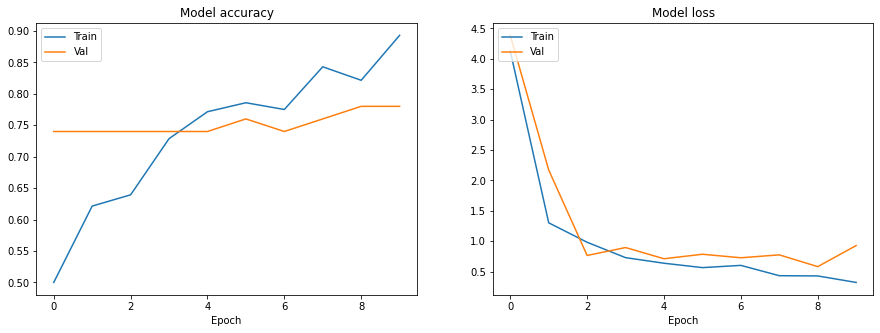

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

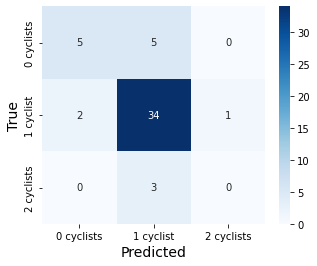

In [108]:
# Calculate and plot confusion matrices

y_pred_temp = model.predict(images_test)
y_pred = np.argmax(y_pred_temp, axis=1)

#visualizer.plot_confusion_matrix(confusion_matrix(y_test,y_pred))

c_matrix = confusion_matrix(y_test,y_pred)
labels = ['0 cyclists', '1 cyclist', '2 cyclists']
plt.figure(figsize = (5, 4))
sns.heatmap(c_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('True', fontsize = 14)
plt.show()

#print(len(y_test))
#print(len(y_pred))

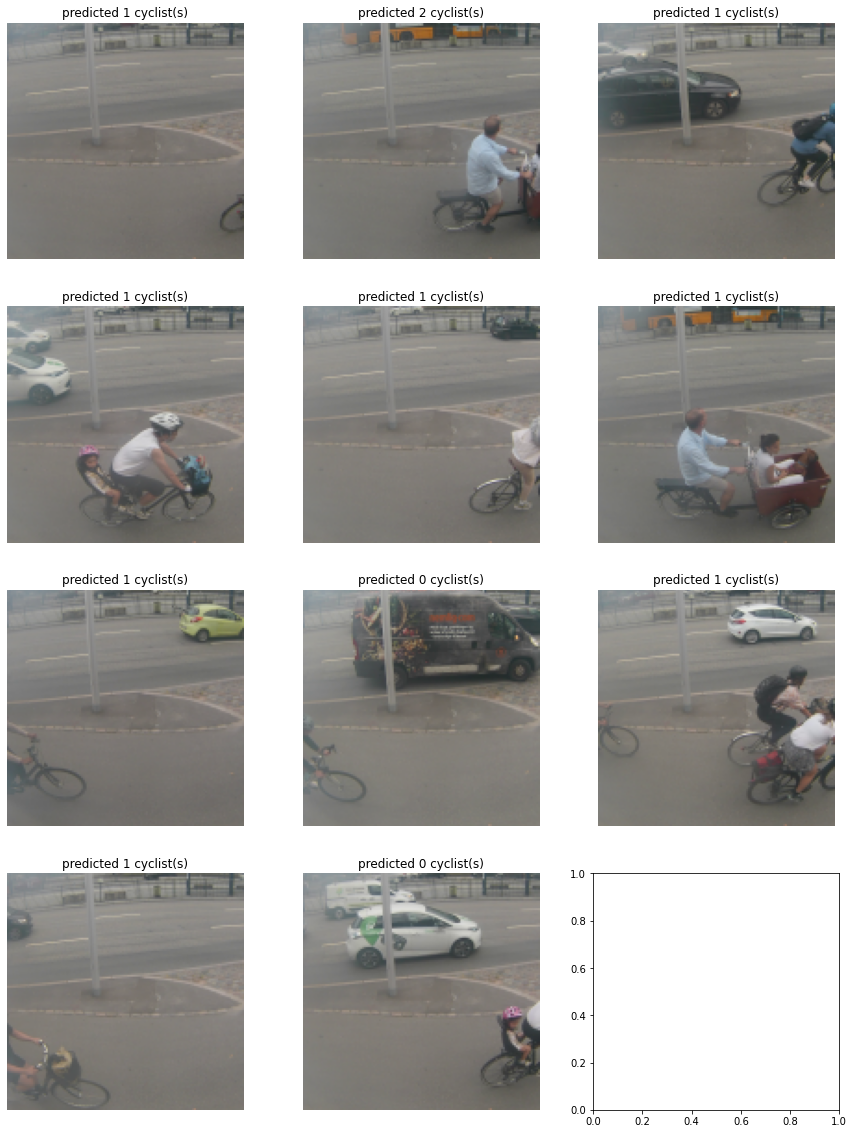

In [124]:
# Looking at wrong (over-)predictions

#overpreds = []
wrongpreds = []

for i in range(len(y_test)):
  #  if y_pred[i] > y_test[i]:
    if y_pred[i] != y_test[i]:
     #   overpreds.append(i)
        wrongpreds.append(i)
        
#Tot = len(overpreds)
Tot = len(wrongpreds)
Cols = 3

# Compute Rows required
Rows = Tot // Cols 
Rows += 1

fig, axs = plt.subplots(Rows, Cols, figsize=(5*Cols, 5*Rows))
get_int = 0
for i in range(Rows):
    for j in range(Cols):
        if get_int >= Tot:
            break;
     #   im = images_test[overpreds[get_int]]
        im = images_test[wrongpreds[get_int]]
        axs[i, j].imshow(im[:,:,[2, 1, 0]])
     #   axs[i, j].set_title('predicted '+str(y_pred[overpreds[get_int]])+' cyclist(s)')
        axs[i, j].set_title('predicted '+str(y_pred[wrongpreds[get_int]])+' cyclist(s)')
        axs[i, j].axis('off')
        get_int += 1